In [63]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.python.keras import layers, Model
from ipywidgets import interact, FloatSlider

In [29]:
def load_images(image_dir='images/'):
    images = []
    for img_file in sorted(os.listdir(image_dir)):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = Image.open(os.path.join(image_dir, img_file)).convert('RGBA')
            img = img.resize((224, 224))
            img_array = np.array(img, dtype=np.float32) / 255.0
            images.append(img_array)
    return np.array(images, dtype=np.float32)

In [30]:
class VAE(Model):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder layers
        self.conv1 = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')
        self.conv2 = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(16, activation='relu')

        # Latent space
        self.z_mean_layer = layers.Dense(latent_dim)
        self.z_log_var_layer = layers.Dense(latent_dim)

        # Decoder layers
        self.dense2 = layers.Dense(56 * 56 * 32, activation='relu')
        self.reshape = layers.Reshape((56, 56, 32))
        self.conv_t1 = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')
        self.conv_t2 = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')
        self.conv_t3 = layers.Conv2DTranspose(4, 3, padding='same', activation='sigmoid')

    def encode(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.dense1(x)

        z_mean = self.z_mean_layer(x)
        z_log_var = self.z_log_var_layer(x)

        return z_mean, z_log_var

    def decode(self, z):
        x = self.dense2(z)
        x = self.reshape(x)
        x = self.conv_t1(x)
        x = self.conv_t2(x)
        x = self.conv_t3(x)
        return x

    def reparameterize(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def call(self, inputs):
        z_mean, z_log_var = self.encode(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decode(z)

        # Save for loss calculation
        self.z_mean = z_mean
        self.z_log_var = z_log_var

        return reconstructed

In [31]:
def vae_loss(model, x):
    reconstruction = model(x)

    squared_diff = tf.square(x - reconstruction)
    reconstruction_loss = tf.reduce_mean(
        tf.reduce_sum(squared_diff, axis=[1, 2, 3])
    )

    kl_loss = -0.5 * tf.reduce_mean(
        tf.reduce_sum(
            1 + model.z_log_var - tf.square(model.z_mean) - tf.exp(model.z_log_var),
            axis=1
        )
    )

    return reconstruction_loss + kl_loss

In [32]:
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = vae_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [ ]:
tf.keras.backend.set_floatx('float32')

# Load images
print("Loading images...")
images = load_images()
print(f"Loaded {len(images)} images with shape {images.shape}")

# Create model
print("Building VAE model...")
vae = VAE(latent_dim=2)
optimizer = tf.keras.optimizers.Adam(1e-4)

# Call once to build the model
_ = vae(images)

# Train
print("Training model...")
epochs = 10000

for epoch in range(epochs):
    loss = train_step(vae, images, optimizer)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy():.4f}")

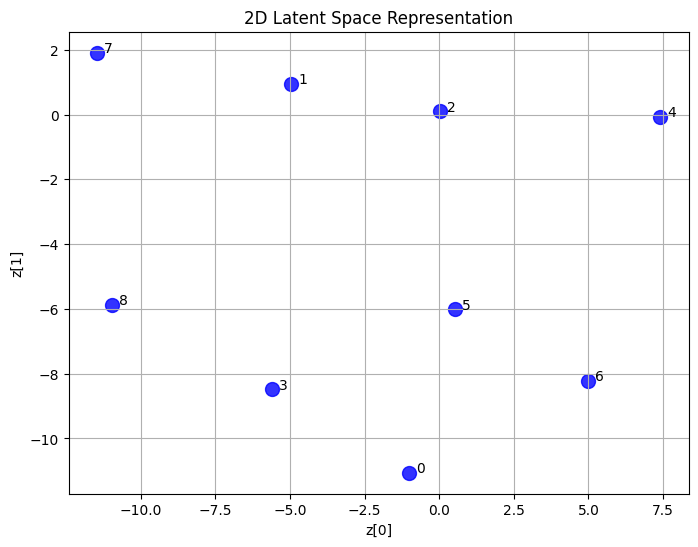

Bounds for sliders: z[0] = [-12.47, 8.41], z[1] = [-12.06, 2.91]


interactive(children=(FloatSlider(value=0.0, description='z[0]', max=8.405804634094238, min=-12.46664047241211…

<function __main__.visualize_latent(z0, z1)>

In [64]:
z_mean, _ = vae.encode(images)
z_mean = z_mean.numpy()

plt.figure(figsize=(8, 6))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c='blue', alpha=0.8, s=100)
for i, (x, y) in enumerate(zip(z_mean[:, 0], z_mean[:, 1])):
    plt.annotate(str(i), xy=(x, y), xytext=(5, 0), textcoords='offset points')
plt.title('2D Latent Space Representation')
plt.xlabel('z[0]')
plt.ylabel('z[1]')
plt.grid(True)
plt.show()

min_x, max_x = z_mean[:, 0].min() - 1, z_mean[:, 0].max() + 1
min_y, max_y = z_mean[:, 1].min() - 1, z_mean[:, 1].max() + 1
print(f"Bounds for sliders: z[0] = [{min_x:.2f}, {max_x:.2f}], z[1] = [{min_y:.2f}, {max_y:.2f}]")

def visualize_latent(z0, z1):
    z_sample = np.array([[z0, z1]], dtype=np.float32)
    x_decoded = vae.decode(z_sample)
    plt.figure(figsize=(3, 3))
    plt.imshow(x_decoded[0].numpy())
    plt.axis('off')
    plt.title(f"z = [{z0:.2f}, {z1:.2f}]")
    plt.show()

interact(
    visualize_latent,
    z0=FloatSlider(value=0, min=min_x, max=max_x, step=0.1, description='z[0]'),
    z1=FloatSlider(value=0, min=min_y, max=max_y, step=0.1, description='z[1]')
)

In [54]:
class Decoder(tf.Module):
    def __init__(self, vae):
        super().__init__()
        self.dense2 = vae.dense2
        self.reshape = vae.reshape
        self.conv_t1 = vae.conv_t1
        self.conv_t2 = vae.conv_t2
        self.conv_t3 = vae.conv_t3

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, vae.latent_dim], dtype=tf.float32)])
    def __call__(self, z):
        x = self.dense2(z)
        x = self.reshape(x)
        x = self.conv_t1(x)
        x = self.conv_t2(x)
        x = self.conv_t3(x)
        return x

decoder = Decoder(vae)
tf.saved_model.save(decoder, "decoder_model", signatures={'serving_default': decoder.__call__})

In [55]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model decoder_model/ web_decoder_model/

2025-05-29 04:22:20.755851: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748492540.776950   16068 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748492540.783256   16068 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-29 04:22:25.254263: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1748492545.254437   16068 gpu_device.cc:2022] Created device /job:localhost/replica:0/task